In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
from scipy.special import expit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from causallib.estimation import IPW


In [2]:
def generate_data(n=1000, seed=0):
    rng = np.random.default_rng(seed)
    
    X = rng.normal(0, 0.5, size=(n, 4))
    a_beta = np.array([0, 1, 0, 1])
    a_logit = X @ a_beta
    a_prop = expit(a_logit)
    a = rng.binomial(1, a_prop)

    y_beta = np.array([0, 0, -1, -1])
    effect = 1
    y = X @ y_beta + a * effect + rng.normal(0, 1, size=n)
    
    X = pd.DataFrame(X, columns=["x0", "xa", "xy", "xay"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

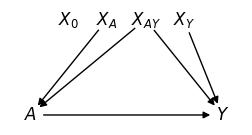

In [24]:
fig, ax = mpl.pyplot.subplots(1, 1, figsize=(3,1.5))
G = nx.DiGraph([
    ("$A$", "$Y$"), 
    # ("$X_0$", None),
    ("$X_A$", "$A$"),
    ("$X_{AY}$", "$A$"), ("$X_{AY}$", "$Y$"), 
    ("$X_Y$", "$Y$"),
])
G.add_node("$X_0$")
pos = {
    "$A$":[0,0], "$Y$":[5,0],
    "$X_0$":[1, 2], "$X_A$":[2,2],
    "$X_{AY}$":[3, 2], "$X_Y$":[4, 2],
}
nx.draw(G, pos=pos, ax=ax, with_labels=True, node_color="white")

In [3]:
X, a, y = generate_data()
X.join(a).join(y)

,x0,xa,xy,xay,a,y
0,0.062865,-0.066052,0.320211,0.052450,1,1.477364
1,-0.267835,0.180798,0.652000,0.473540,0,-1.847662
2,-0.351868,-0.632711,-0.311637,0.020663,0,0.689057
3,-1.162515,-0.109396,-0.622955,-0.366134,0,1.917618
4,-0.272129,-0.158150,0.205815,0.521257,1,-1.060988
...,...,...,...,...,...,...
995,-0.450861,1.003341,0.823907,-0.154471,1,1.280002
996,-0.827534,-0.510914,-0.101346,-0.120888,1,2.251462
997,0.859242,-0.639025,-0.057299,-0.096433,1,1.472600
998,0.411003,-0.116951,-0.140148,-0.009453,0,1.207335


In [4]:
ipw = IPW(LogisticRegression(penalty="none"))
ipw.fit(X, a)
w = ipw.compute_weights(X, a)

In [5]:
def calculate_asmd(X, a, w=None):
    eps = np.finfo(X.dtypes.iloc[0]).resolution  # .eps
    if w is None:
        w = pd.Series(1, index=a.index)
    
    is_treated = a == 1
    x1 = sm.stats.DescrStatsW(X.loc[is_treated], weights=w.loc[is_treated])
    x0 = sm.stats.DescrStatsW(X.loc[~is_treated], weights=w.loc[~is_treated])

    x1_mean = pd.Series(x1.mean, index=X.columns)
    x0_mean = pd.Series(x0.mean, index=X.columns)
    x1_var = pd.Series(x1.var, index=X.columns)
    x0_var = pd.Series(x0.var, index=X.columns)

    smds = (x1_mean - x0_mean) / np.sqrt(x0_var + x1_var + eps)
    asmds = smds.abs()
    asmds.name = "asmd"
    return asmds

In [6]:
asmds = pd.concat({
    "weighted": calculate_asmd(X, a, w),
    "unweighted": calculate_asmd(X, a),
}, names=["adjustment", "covariate"])
asmds

adjustment  covariate
weighted    x0           0.002535
            xa           0.001482
            xy           0.000966
            xay          0.002014
unweighted  x0           0.015296
            xa           0.314791
            xy           0.053678
            xay          0.209638
Name: asmd, dtype: float64

Feature importance measures:
  * absolute coefficients (regression)
  * impurity-based importance (random forest)
  * permutation-based importance (random forest)
  * leave-one-out compare some loss/accuracy (generic)[sounds like a Harrell thing]
    * decrease in accuracy

In [7]:
def leave_one_out_importance(estimator, X, a, y):
    results = []

    for col in ["full"] + X.columns.tolist():
        curX = X.drop(columns=col, errors="ignore")
        curXa = curX.join(a)
        estimator.fit(curXa, y)
        y_pred = estimator.predict(curXa)
        result = {
            "covariate": col,
            "r2": r2_score(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
        }
        results.append(result)
    results = pd.DataFrame(results)
    return results

def relative_explained_variation(estimator, X, a, y, metric="mse"):
    """Harrell: https://www.fharrell.com/post/addvalue/"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = importance / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    return importance

def decrease_in_explain_variation(estimator, X, a, y, metric="mse"):
    """https://stackoverflow.com/q/31343563"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = (importance.loc["full"]-importance) / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    importance = importance.abs()
    return importance


In [8]:
# i = leave_one_out_importance(LinearRegression(), X, a, y)
# i = i.set_index("covariate")
# i
# relative_explained_variation(LinearRegression(), X, a, y)
feature_importance = decrease_in_explain_variation(LinearRegression(), X, a, y)
feature_importance

,r2,mse,mae
covariate,,,
x0,0.000356,0.000235,0.000600
xa,0.000038,0.000025,0.000139
xy,0.402544,0.266615,0.123345
xay,0.340198,0.225322,0.113050


In [9]:
dot_plot_data = asmds.reset_index().merge(
    feature_importance.reset_index(), on="covariate",
)
dot_plot_data

,adjustment,covariate,asmd,r2,mse,mae
0,weighted,x0,0.002535,0.000356,0.000235,0.000600
1,weighted,xa,0.001482,0.000038,0.000025,0.000139
2,weighted,xy,0.000966,0.402544,0.266615,0.123345
3,weighted,xay,0.002014,0.340198,0.225322,0.113050
4,unweighted,x0,0.015296,0.000356,0.000235,0.000600
5,unweighted,xa,0.314791,0.000038,0.000025,0.000139
6,unweighted,xy,0.053678,0.402544,0.266615,0.123345
7,unweighted,xay,0.209638,0.340198,0.225322,0.113050


In [45]:
range_plot_data = plot_data.pivot(
    columns="adjustment", index="covariate", values="asmd"
).agg(["min", "max"], axis="columns")
range_plot_data

,min,max
covariate,,
x0,0.002535,0.015296
xa,0.001482,0.314791
xay,0.002014,0.209638
xy,0.000966,0.053678


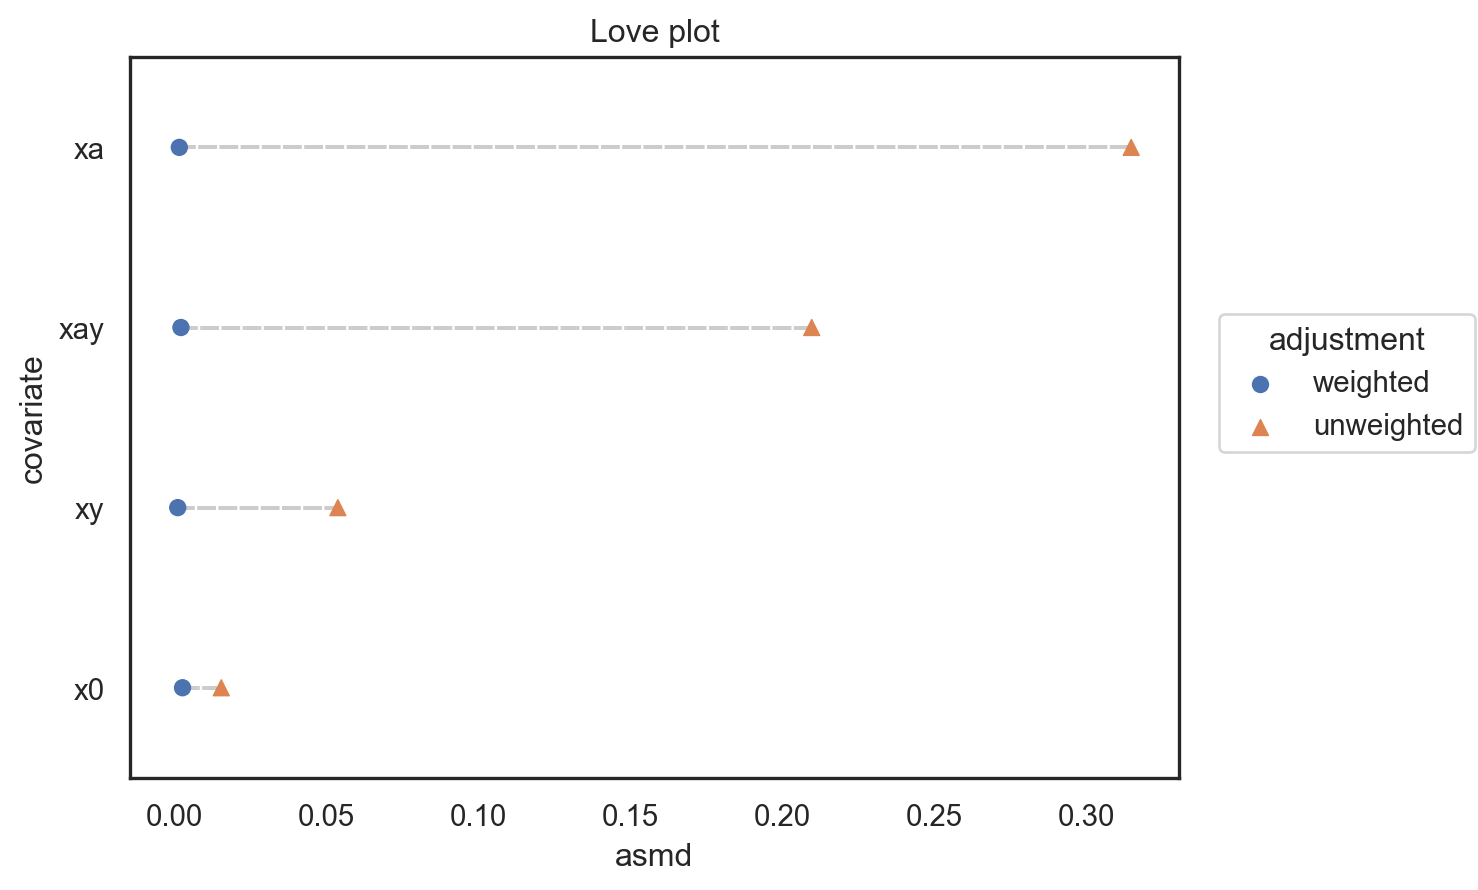

In [83]:
def love_plot(dot_plot_data, plot_range=False, threshold=None, ax=None):
    # order by unweighted:
    y_order = dot_plot_data.query("adjustment=='unweighted'").sort_values("asmd", ascending=False)["covariate"].tolist()
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="adjustment", marker="adjustment",
        data=dot_plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).theme(
        sns.axes_style("white")
    ).label(
        title="Love plot"
    )
    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns")
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            data=range_plot_data,
        )
    if threshold is not None:
        pass
    if ax is not None:
        p = p.on(ax).plot()
    return p

love_plot(dot_plot_data, True)

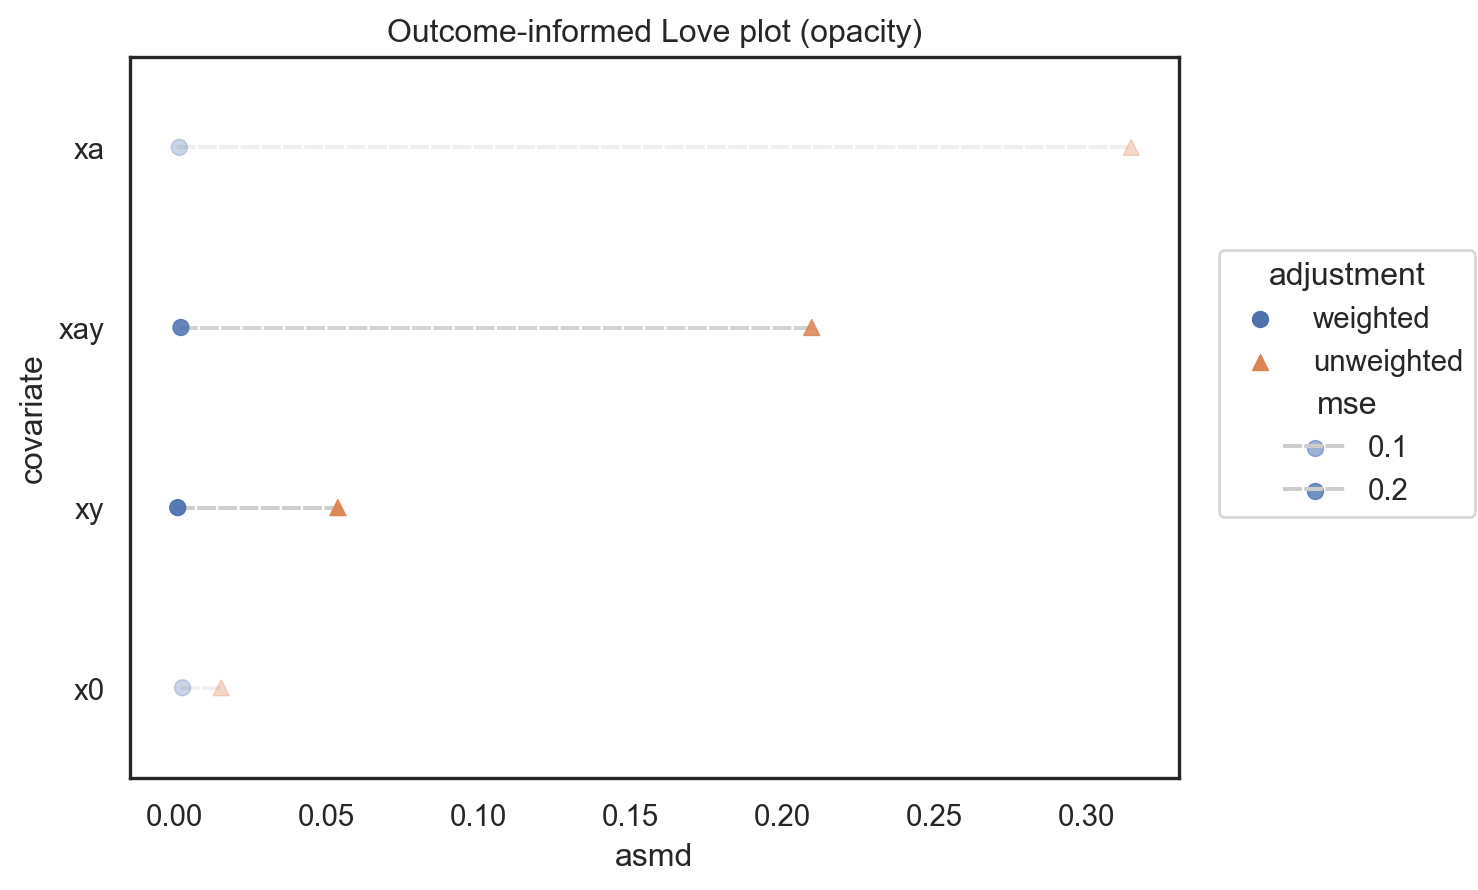

In [84]:
def love_plot_opacity(dot_plot_data, plot_range=False, threshold=None, ax=None):
    # order by unweighted:
    y_order = dot_plot_data.query("adjustment=='unweighted'").sort_values("asmd", ascending=False)["covariate"].tolist()
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="adjustment", marker="adjustment",
        alpha="mse",
        data=plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).theme(
        sns.axes_style("white")
    ).label(
        title="Outcome-informed Love plot (opacity)"
    )
    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns").merge(
            dot_plot_data.query("adjustment=='unweighted'"),
            on="covariate",
        )
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            alpha="mse",
            data=range_plot_data,
        )
    if threshold is not None:
        pass
    if ax is not None:
        p = p.on(ax).plot()
    return p

love_plot_opacity(dot_plot_data, True)

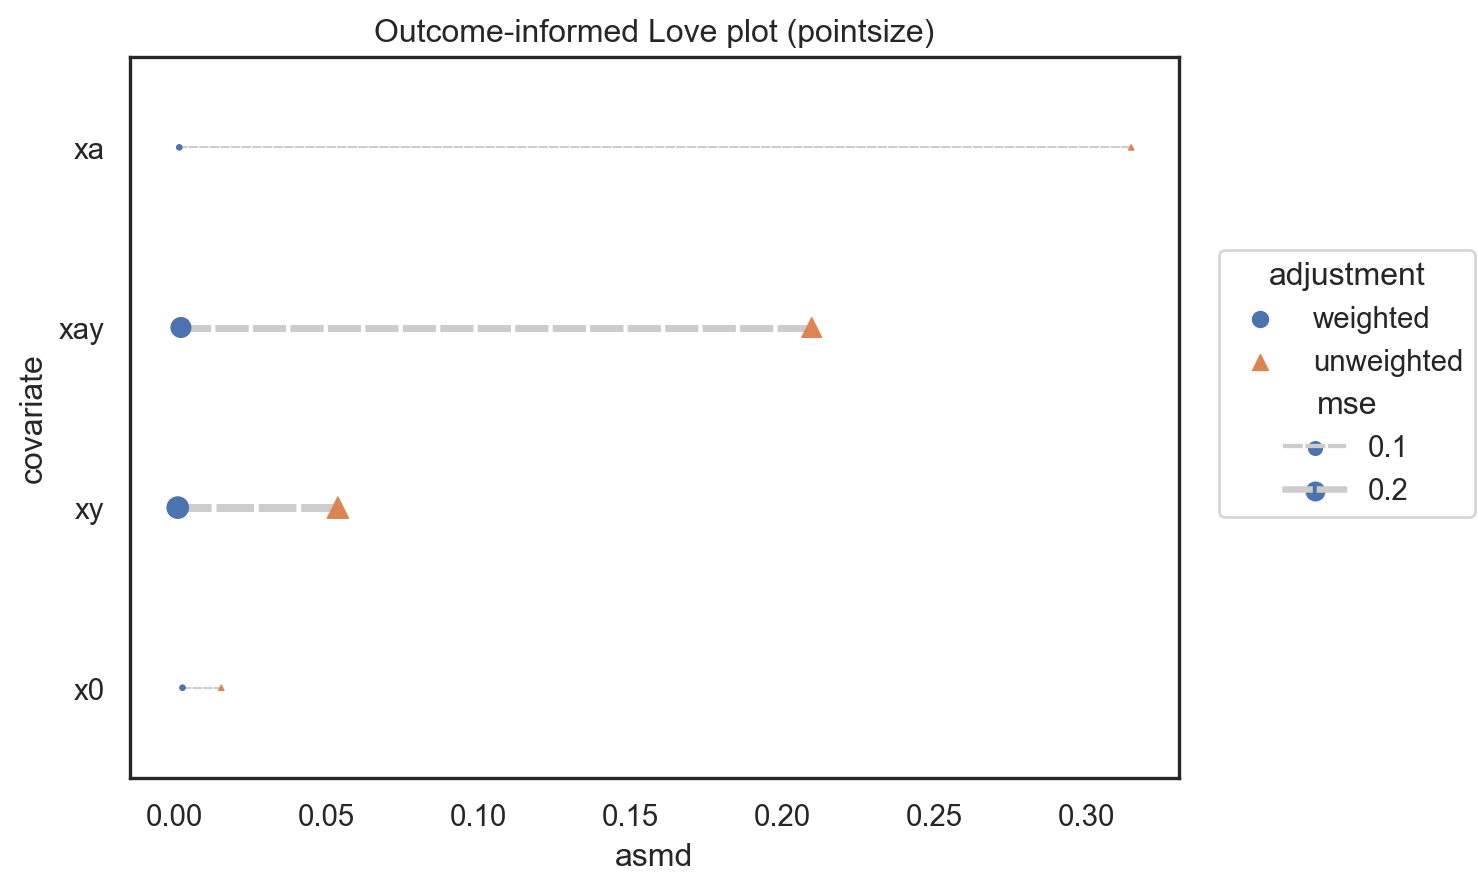

In [85]:
def love_plot_pointsize(dot_plot_data, plot_range=False, threshold=None, ax=None):
    # order by unweighted:
    y_order = dot_plot_data.query("adjustment=='unweighted'").sort_values("asmd", ascending=False)["covariate"].tolist()
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="adjustment", marker="adjustment",
        pointsize="mse",
        data=plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).theme(
        sns.axes_style("white")
    ).label(
        title="Outcome-informed Love plot (pointsize)"
    )
    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns").merge(
            dot_plot_data.query("adjustment=='unweighted'"),
            on="covariate",
        )
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            linewidth="mse",
            data=range_plot_data,
        )
    if threshold is not None:
        pass
    if ax is not None:
        p = p.on(ax).plot()
    return p


love_plot_pointsize(dot_plot_data, True)

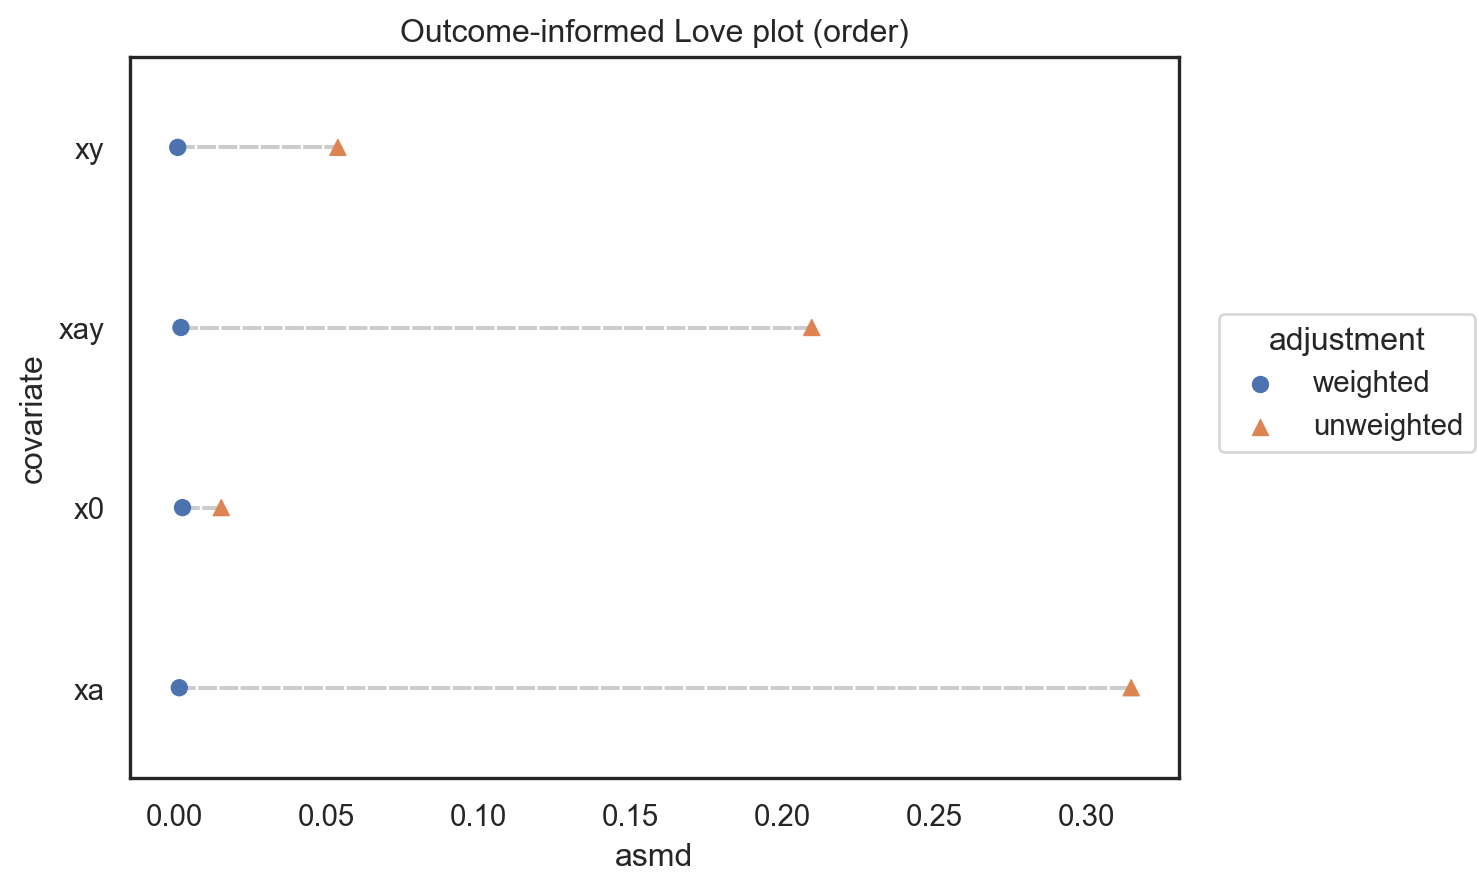

In [86]:
def love_plot_order(dot_plot_data, plot_range=False, threshold=None, ax=None):
    # order by outcome importance:
    y_order = plot_data.query("adjustment=='unweighted'").sort_values("mse", ascending=False)["covariate"].tolist()
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="adjustment", marker="adjustment",
        data=plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).theme(
        sns.axes_style("white")
    ).label(
        title="Outcome-informed Love plot (order)"
    )
    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns").merge(
            dot_plot_data.query("adjustment=='unweighted'"),
            on="covariate",
        )
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            data=range_plot_data,
        )
    if threshold is not None:
        pass
    if ax is not None:
        p = p.on(ax).plot()
    return p

love_plot_order(dot_plot_data, True)

In [120]:
def love_plot_all(
    dot_plot_data, 
    plot_range=False, 
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=True,
    threshold=None, ax=None,
):
    order_by = importance_metric if order_by_importance else "asmd"
    y_order = dot_plot_data.query("adjustment=='unweighted'").sort_values(order_by, ascending=False)["covariate"].tolist()
    
    p = so.Plot(
    ).add(
        so.Dot(), 
        y="covariate",
        x="asmd",
        color="adjustment", marker="adjustment",
        pointsize=importance_metric if pointsize else None,
        alpha=importance_metric if opacity else None,
        legend=legend,
        data=dot_plot_data,
    ).scale(
        marker=dict(weighted="o", unweighted="^"),
        y=so.Nominal(order=y_order),
    ).label(
        x="Absolute standardized mean difference",
        y="Covariate",
    ).theme(
        sns.axes_style("white")
    )

    if plot_range:
        range_plot_data = dot_plot_data.pivot(
            columns="adjustment", index="covariate", values="asmd"
        ).agg(["min", "max"], axis="columns").merge(
            dot_plot_data.query("adjustment=='unweighted'"),
            on="covariate",
        )
        p = p.add(
            so.Range(linestyle="--", color="0.8", artist_kws=dict(zorder=0)), 
            y="covariate",
            xmin="min", xmax="max",
            linewidth=importance_metric if pointsize else None,
            alpha=importance_metric if opacity else None,
            legend=legend,
            data=range_plot_data,
        )
    if threshold is not None:
        ax.axvline(0.1, linestyle="--", color="0.6", zorder=0)
    if ax is not None:
        p = p.on(ax).plot()
    return p


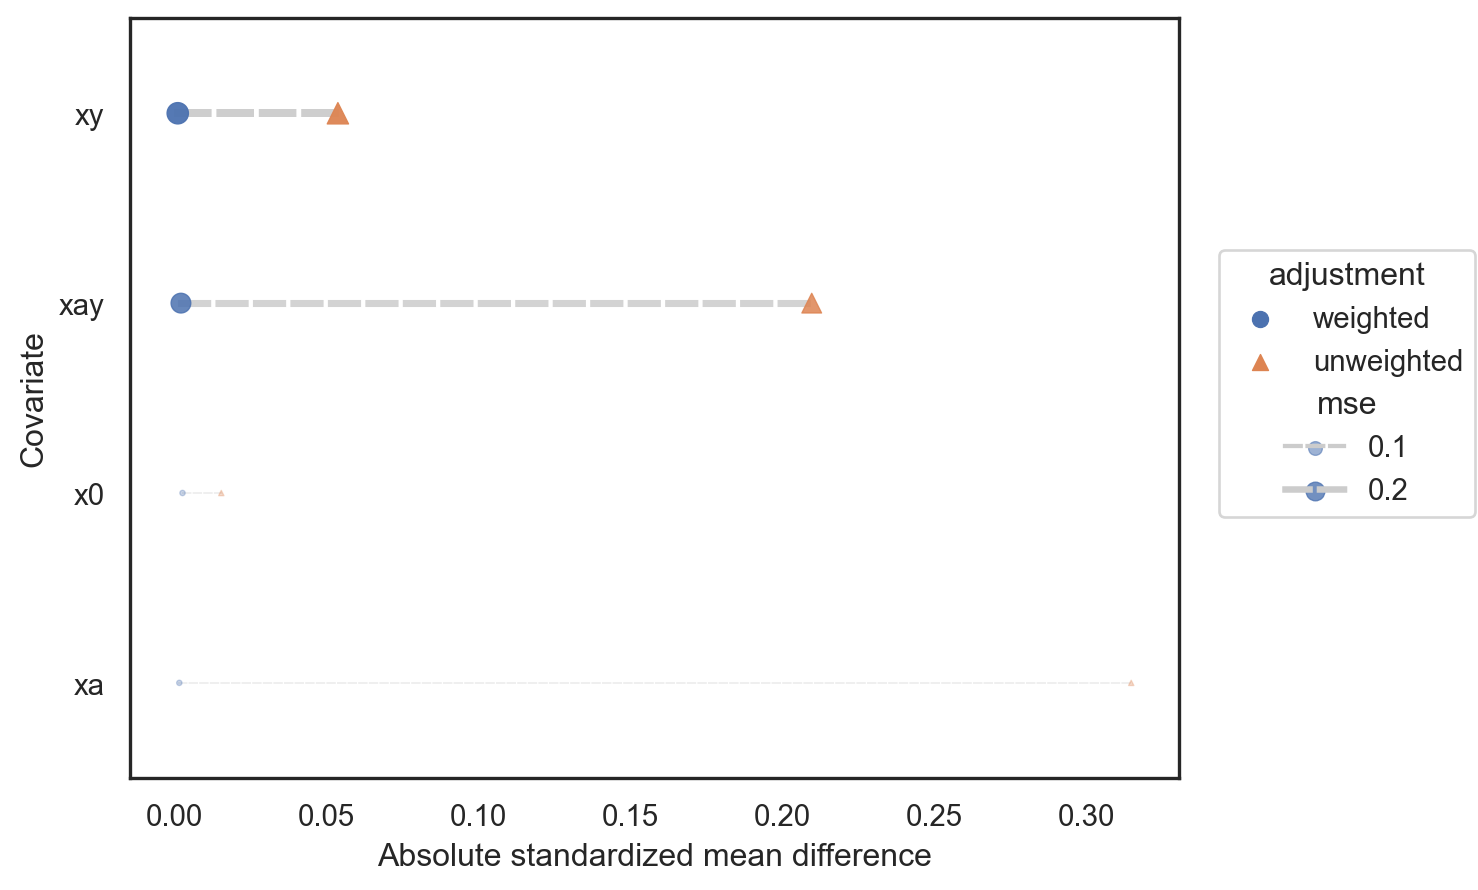

In [121]:
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=True,
    opacity=True,
    pointsize=True,
    importance_metric="mse",
    threshold=None, ax=None,
)

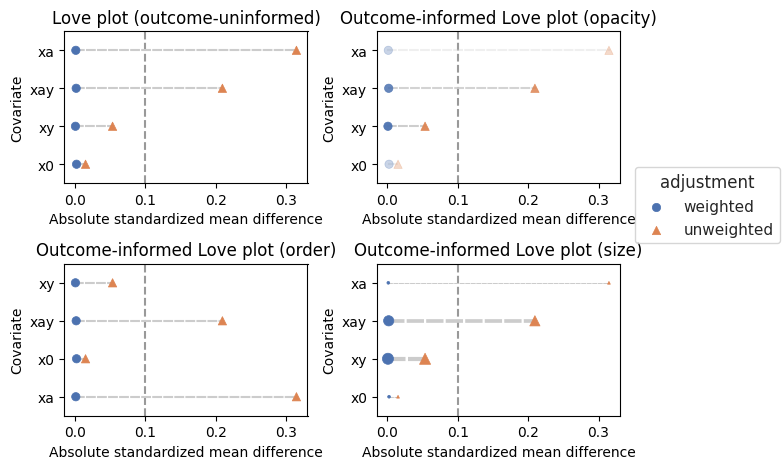

In [122]:
fig = mpl.figure.Figure()
axes = fig.subplot_mosaic("AB\nCD")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Love plot (outcome-uninformed)")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=True,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["B"],
)
axes["B"].set_title("Outcome-informed Love plot (opacity)")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=True,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["C"],
)
axes["C"].set_title("Outcome-informed Love plot (order)")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=True,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["D"],
)
axes["D"].set_title("Outcome-informed Love plot (size)")
fig.tight_layout()
fig

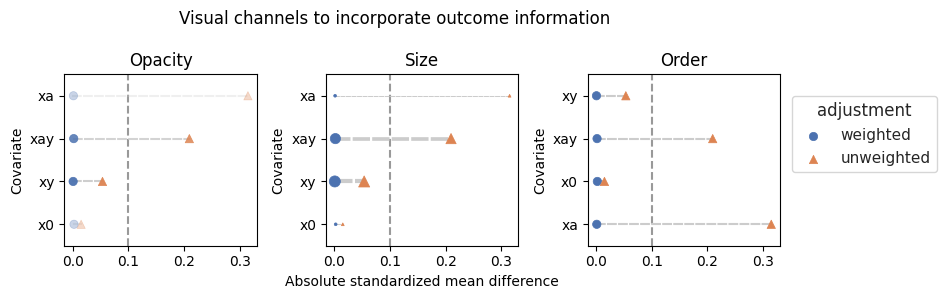

In [126]:
fig = mpl.figure.Figure(figsize=(8, 3))
axes = fig.subplot_mosaic("BCD")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=True,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["B"],
)
axes["B"].set_title("Opacity")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=True,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=True,
    threshold=0.1, ax=axes["D"],
)
axes["D"].set_title("Order")
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=True,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["C"],
)
axes["C"].set_title("Size")
axes["B"].set_xlabel(None)
axes["D"].set_xlabel(None)
fig.suptitle("Visual channels to incorporate outcome information")
fig.tight_layout()
fig

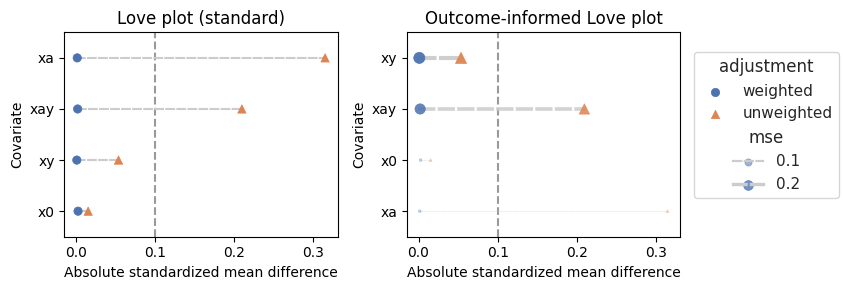

In [128]:
fig = mpl.figure.Figure(figsize=(7, 3))
axes = fig.subplot_mosaic("AE", sharex=True)
love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=False,
    opacity=False,
    pointsize=False,
    importance_metric="mse",
    legend=False,
    threshold=0.1, ax=axes["A"],
)
axes["A"].set_title("Love plot (standard)")

love_plot_all(
    dot_plot_data, 
    plot_range=True,
    order_by_importance=True,
    opacity=True,
    pointsize=True,
    importance_metric="mse",
    legend=True,
    threshold=0.1, ax=axes["E"],
)
axes["E"].set_title("Outcome-informed Love plot")
fig.tight_layout()
fig

## Combinging ASMD and FI in a single metric to allow selection

In [11]:
ouiasmd = dot_plot_data.query("adjustment=='unweighted'").drop(columns="adjustment")
ouiasmd

,covariate,asmd,r2,mse,mae
4,x0,0.015296,0.000356,0.000235,0.000600
5,xa,0.314791,0.000038,0.000025,0.000139
6,xy,0.053678,0.402544,0.266615,0.123345
7,xay,0.209638,0.340198,0.225322,0.113050


In [12]:
outcome_metric = "mse"
ouiasmd["ouiasmd"] = ouiasmd["asmd"] * ouiasmd[outcome_metric]
ouiasmd

,covariate,asmd,r2,mse,mae,ouiasmd
4,x0,0.015296,0.000356,0.000235,0.000600,0.000004
5,xa,0.314791,0.000038,0.000025,0.000139,0.000008
6,xy,0.053678,0.402544,0.266615,0.123345,0.014311
7,xay,0.209638,0.340198,0.225322,0.113050,0.047236


In [20]:
ouiasmd_long = ouiasmd.melt(
    id_vars="covariate",
    var_name="metric",
)
ouiasmd_long = ouiasmd_long.loc[ouiasmd_long["metric"].isin(["asmd", outcome_metric, "ouiasmd"])]

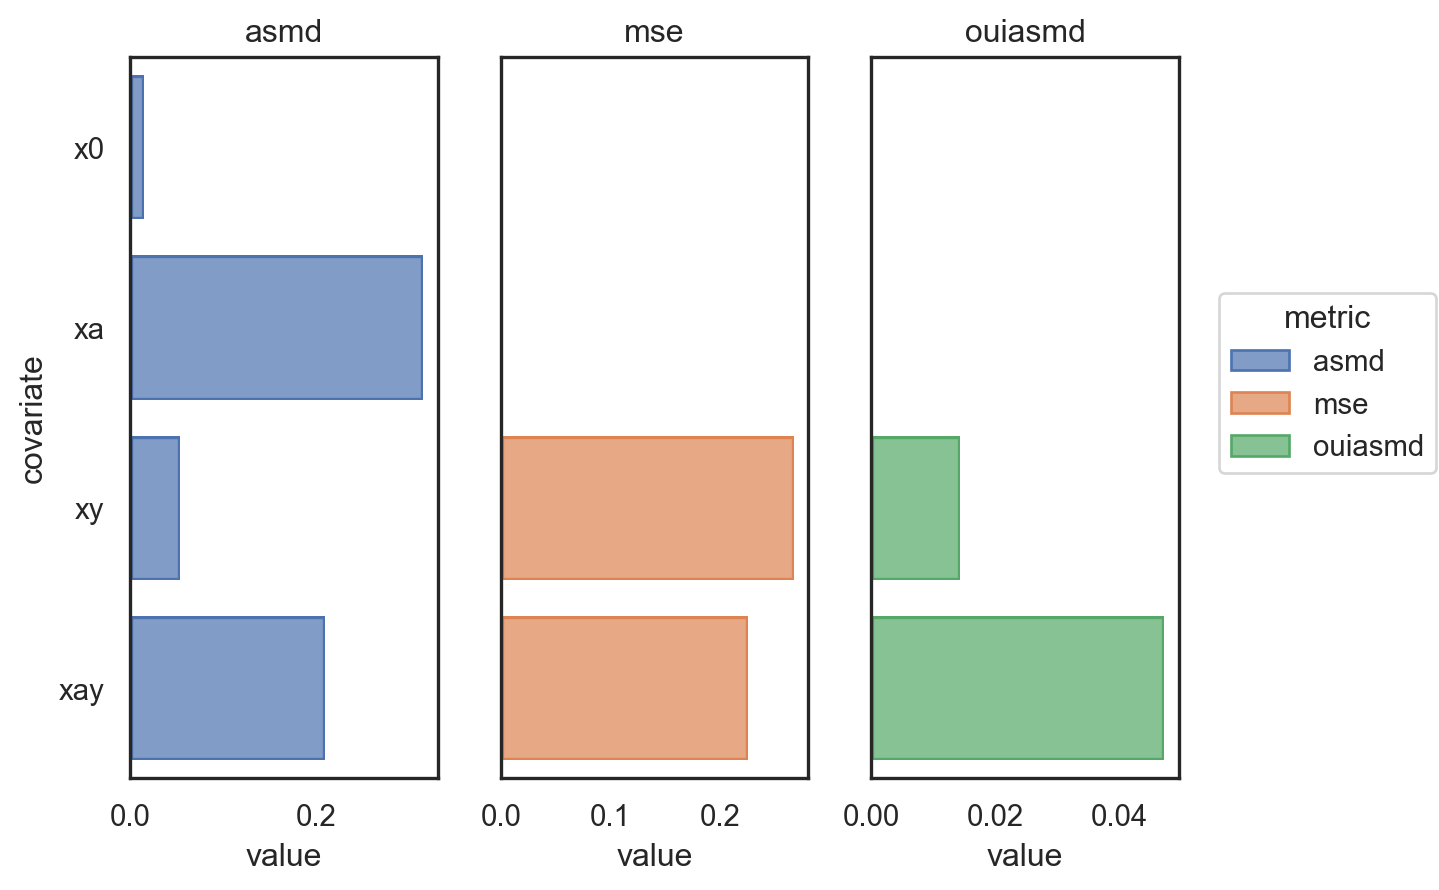

In [23]:
so.Plot(
    ouiasmd_long,
    y="covariate",
    x="value",
    color="metric",
).facet(
    col="metric"
).add(
    so.Bar()
).share(
    y=True,
    x=False,
).theme(
    sns.axes_style("white")
)

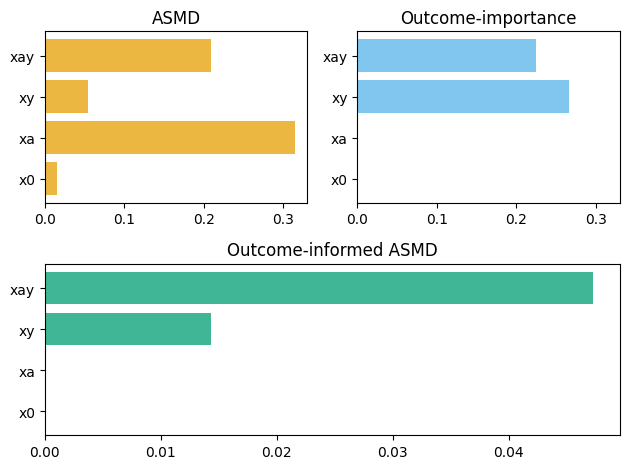

In [36]:
# fig = mpl.figure.Figure(figsize=(8, 3))
fig, axes = mpl.pyplot.subplot_mosaic(
    """
    AB
    CC
    """,
    # sharey=True,
)
bar_kwargs = {"alpha": 0.75}
axes["A"].barh(ouiasmd["covariate"], ouiasmd["asmd"], color="#E69F00", **bar_kwargs)
axes["B"].barh(ouiasmd["covariate"], ouiasmd[outcome_metric], color="#56B4E9", **bar_kwargs)
axes["C"].barh(ouiasmd["covariate"], ouiasmd["ouiasmd"], color="#009E73", **bar_kwargs)
axes["A"].sharex(axes["B"])
axes["A"].set_title("ASMD")
axes["B"].set_title("Outcome-importance")
axes["C"].set_title("Outcome-informed ASMD")
fig.tight_layout()


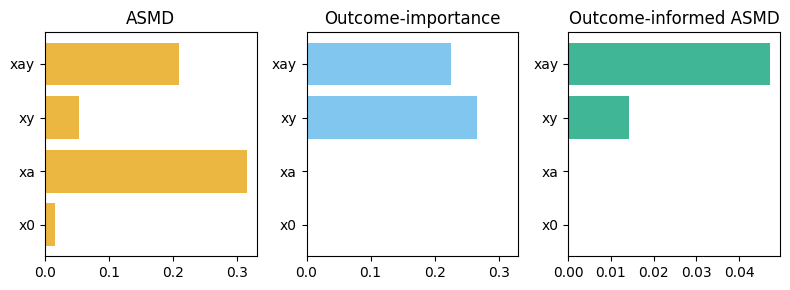

In [38]:
# fig = mpl.figure.Figure(figsize=(8, 3))
fig, axes = mpl.pyplot.subplot_mosaic(
    """
    ABC
    """,
    # sharey=True,
    figsize=(8,3)
)
bar_kwargs = {"alpha": 0.75}
axes["A"].barh(ouiasmd["covariate"], ouiasmd["asmd"], color="#E69F00", **bar_kwargs)
axes["B"].barh(ouiasmd["covariate"], ouiasmd[outcome_metric], color="#56B4E9", **bar_kwargs)
axes["C"].barh(ouiasmd["covariate"], ouiasmd["ouiasmd"], color="#009E73", **bar_kwargs)
axes["A"].sharex(axes["B"])
axes["A"].set_title("ASMD")
axes["B"].set_title("Outcome-importance")
axes["C"].set_title("Outcome-informed ASMD")
fig.tight_layout()


Try to rescale outcome importance to ASMD

In [39]:
def calculate_decomposed_smd(X, a, w=None):
    eps = np.finfo(X.dtypes.iloc[0]).resolution  # .eps
    if w is None:
        w = pd.Series(1, index=a.index)
    
    is_treated = a == 1
    x1 = sm.stats.DescrStatsW(X.loc[is_treated], weights=w.loc[is_treated])
    x0 = sm.stats.DescrStatsW(X.loc[~is_treated], weights=w.loc[~is_treated])

    x1_mean = pd.Series(x1.mean, index=X.columns)
    x0_mean = pd.Series(x0.mean, index=X.columns)
    x1_var = pd.Series(x1.var, index=X.columns)
    x0_var = pd.Series(x0.var, index=X.columns)

    numerator = (x1_mean - x0_mean) 
    denominator = np.sqrt(x0_var + x1_var + eps)
    return numerator, denominator

In [40]:
_, scale = calculate_decomposed_smd(X, a, w)
scale

x0     0.697658
xa     0.682818
xy     0.723220
xay    0.718717
dtype: float64

In [52]:
ouiasmd_scaled = ouiasmd.set_index("covariate")
ouiasmd_scaled["ouiasmd_scaled"] = ouiasmd_scaled["asmd"] * (ouiasmd_scaled[outcome_metric] / scale)
ouiasmd_scaled = ouiasmd_scaled.reset_index()
ouiasmd_scaled

,covariate,asmd,r2,mse,mae,ouiasmd,ouiasmd_scaled
0,x0,0.015296,0.000356,0.000235,0.000600,0.000004,0.000005
1,xa,0.314791,0.000038,0.000025,0.000139,0.000008,0.000012
2,xy,0.053678,0.402544,0.266615,0.123345,0.014311,0.019788
3,xay,0.209638,0.340198,0.225322,0.113050,0.047236,0.065723


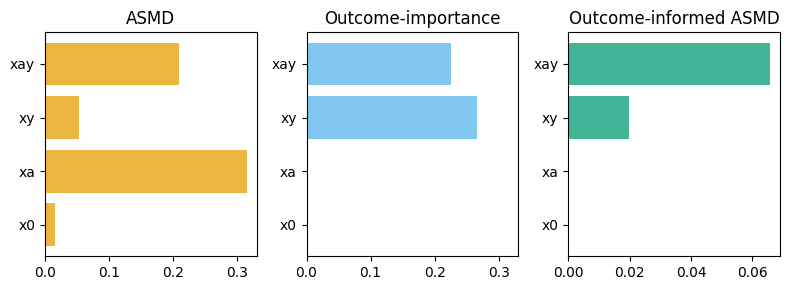

In [53]:
# fig = mpl.figure.Figure(figsize=(8, 3))
fig, axes = mpl.pyplot.subplot_mosaic(
    """
    ABC
    """,
    # sharey=True,
    figsize=(8,3)
)
bar_kwargs = {"alpha": 0.75}
axes["A"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled["asmd"], color="#E69F00", **bar_kwargs)
axes["B"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled[outcome_metric], color="#56B4E9", **bar_kwargs)
axes["C"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled["ouiasmd_scaled"], color="#009E73", **bar_kwargs)
axes["A"].sharex(axes["B"])
axes["A"].set_title("ASMD")
axes["B"].set_title("Outcome-importance")
axes["C"].set_title("Outcome-informed ASMD")
fig.tight_layout()


In [55]:
ouiasmd_scaled = ouiasmd.set_index("covariate")
scale = ouiasmd_scaled[outcome_metric] / ouiasmd_scaled[outcome_metric].sum()
ouiasmd_scaled["ouiasmd_scaled"] = ouiasmd_scaled["asmd"] * scale
ouiasmd_scaled = ouiasmd_scaled.reset_index()
ouiasmd_scaled

,covariate,asmd,r2,mse,mae,ouiasmd,ouiasmd_scaled
0,x0,0.015296,0.000356,0.000235,0.000600,0.000004,0.000007
1,xa,0.314791,0.000038,0.000025,0.000139,0.000008,0.000016
2,xy,0.053678,0.402544,0.266615,0.123345,0.014311,0.029076
3,xay,0.209638,0.340198,0.225322,0.113050,0.047236,0.095970


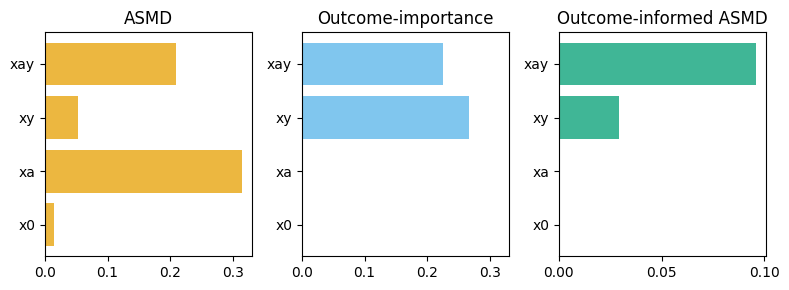

In [56]:
# fig = mpl.figure.Figure(figsize=(8, 3))
fig, axes = mpl.pyplot.subplot_mosaic(
    """
    ABC
    """,
    # sharey=True,
    figsize=(8,3)
)
bar_kwargs = {"alpha": 0.75}
axes["A"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled["asmd"], color="#E69F00", **bar_kwargs)
axes["B"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled[outcome_metric], color="#56B4E9", **bar_kwargs)
axes["C"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled["ouiasmd_scaled"], color="#009E73", **bar_kwargs)
axes["A"].sharex(axes["B"])
axes["A"].set_title("ASMD")
axes["B"].set_title("Outcome-importance")
axes["C"].set_title("Outcome-informed ASMD")
fig.tight_layout()


In [57]:
ouiasmd_scaled = ouiasmd.set_index("covariate")
scale2 = ouiasmd_scaled[outcome_metric] / ouiasmd_scaled[outcome_metric].sum()
scale1 = ouiasmd_scaled["asmd"] / ouiasmd_scaled["asmd"].sum()
ouiasmd_scaled["ouiasmd_scaled"] = scale2 * scale1
ouiasmd_scaled = ouiasmd_scaled.reset_index()
ouiasmd_scaled

,covariate,asmd,r2,mse,mae,ouiasmd,ouiasmd_scaled
0,x0,0.015296,0.000356,0.000235,0.000600,0.000004,0.000012
1,xa,0.314791,0.000038,0.000025,0.000139,0.000008,0.000027
2,xy,0.053678,0.402544,0.266615,0.123345,0.014311,0.048999
3,xay,0.209638,0.340198,0.225322,0.113050,0.047236,0.161728


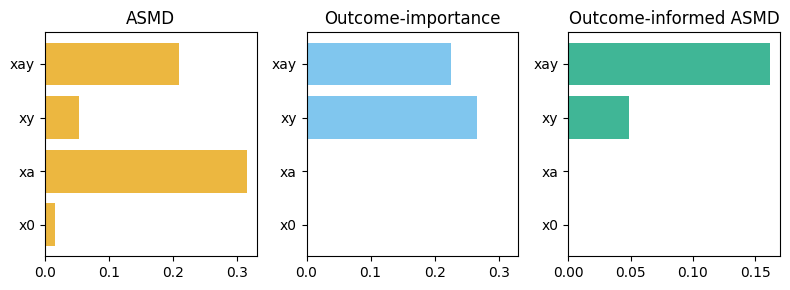

In [58]:
# fig = mpl.figure.Figure(figsize=(8, 3))
fig, axes = mpl.pyplot.subplot_mosaic(
    """
    ABC
    """,
    # sharey=True,
    figsize=(8,3)
)
bar_kwargs = {"alpha": 0.75}
axes["A"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled["asmd"], color="#E69F00", **bar_kwargs)
axes["B"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled[outcome_metric], color="#56B4E9", **bar_kwargs)
axes["C"].barh(ouiasmd_scaled["covariate"], ouiasmd_scaled["ouiasmd_scaled"], color="#009E73", **bar_kwargs)
axes["A"].sharex(axes["B"])
axes["A"].set_title("ASMD")
axes["B"].set_title("Outcome-importance")
axes["C"].set_title("Outcome-informed ASMD")
fig.tight_layout()


In [64]:
scale1.sum()
scale2.sum()
ouiasmd_scaled["ouiasmd_scaled"].sum()

0.2107663105434979